## Summary: Statistical effects on Edelweiss C

This notebook examines the error on the paramters C and m in the case where nothing else is allowed to vary.

In [1]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
from scipy import optimize
import lmfit as lmf
import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [2]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

In [3]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

## Fit with an MCMC method

In [4]:
def log_likelihood(theta, ER_data, NR_data, pars):
    C, m = theta
    aH, scale, A, B = pars
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x, y, yerr = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    
    # expected parameter values and widths
    # scale width estimated by assuming a 10 mV error on V and 0.5 eV error on epsilon
    # information for A and B from Astroparticle Physics 14 (2001) 329±337
    exp_aH = 0.016
    exp_aH_sig = exp_aH*0.046
    exp_scale = 1
    exp_scale_sig = 0.17
    exp_A = 0.16
    exp_A_sig = 0.07
    exp_B = 0.18
    exp_B_sig = 0.1
    
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    model_ER = sigER_func(x_ER)
    sigma2_ER = yerr_ER**2
    model_NR = sigNR_func(x)
    sigma2_NR = yerr**2
    
    return -0.5*(np.sum((y-model_NR)**2/sigma2_NR + np.log(2*np.pi*sigma2_NR)) \
                 + np.sum((y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER)) \
                 + (aH - exp_aH)**2/exp_aH_sig**2 + (scale - exp_scale)**2/exp_scale_sig**2 + (A - exp_A)**2/exp_A_sig**2 + (B - exp_B)**2/exp_B_sig**2)

In [5]:
def gauss_log_prior(theta, pars):
    C, m = theta
    aH, scale, A, B = pars
    
    if -0.5 < aH < 0.5 and 0.02 < C < 0.05 and -1e-3 < m < 1e-3 and 0 < scale < 100 and 0 < A < 0.3 and 0 < B < 0.3:
        return 0.0 
        #return 0.0 - (scale-scale_expected)**2/(2*scale_sig_sq) - (A - A_exp)**2/(2*A_sig_sq) - (B - B_exp)**2/(2*B_sig_sq)
    return -np.inf

In [6]:
def new_log_probability(theta, ER_data, NR_data, pars, prior_func):
    lp = prior_func(theta, pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ER_data, NR_data, pars)

## Find the minimum likelihood

When all six parameters are allowed to vary, the solution finds a small value for A and a larger value for B:

aH, C, m, scale, A, B = x: array([1.42450916e-02, 4.23384048e-02, 1.45366242e-05, 1.17278141e+00,
       5.26524413e-02, 2.84524357e-01])

In [47]:
# start at the minimum determined by the six-parameter fit
aH, C, m, scale, A, B = 1.42450916e-02, 4.23384048e-02, 1.45366242e-05, 1.17278141e+00, 5.26524413e-02, 2.84524357e-01
pars = (aH, scale, A, B)

from scipy import optimize
#np.random.seed(42)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([C, m]) + np.multiply([0.01*C, 0.01*m], np.random.randn(2))
#soln = optimize.minimize(nll, initial, method='Powell', args=(ER_data, NR_data, pars)) #, options={'adaptive':True})
soln = optimize.brute(nll, ([0.03, 0.048], [-0.001, 0.002]), args=(ER_data, NR_data, pars)) #, options={'adaptive':True})

#C_fit, m_fit = soln.x
C_fit, m_fit = soln
print (soln)

[4.23512962e-02 1.42883942e-05]


In [46]:
Test = True

In [9]:
filename = 'data/edelweiss_C_systematicErrors_sampler_nll_Candm_gausPrior.h5'

# random walks starting near the minimum
ndim, nwalkers = 2, 100

    
if not Test:
    pos = [[C_fit, m_fit] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, new_log_probability, args=(ER_data, NR_data, pars, gauss_log_prior))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain
    
else:
    f = h5py.File(filename,'r')

    # need to store data in an array:
    # The sampler will now have a chains attribute 
    # which is an array with shape (Nwalker,N,Ndim) 
    # where N is the number of interations (500 in our inital run)
    # and Ndim is the number of fit parameters
    path='{}/{}/'.format('mcmc','sampler')

    C = np.asarray(f[path+'C'])
    m = np.asarray(f[path+'m'])
    samples = np.asarray(f[path+'samples'])

    f.close()

In [10]:
import os.path

if not Test:
    #save the MCMC results
    path='{}/{}/'.format('mcmc','sampler')

    #remove vars
    f = h5py.File(filename,'a')
    exC = path+'C' in f
    exm = path+'m' in f
    
    exsamp = path+'samples' in f

    if exC:
      del f[path+'C']
    if exm:
      del f[path+'m']
    if exsamp:
      del f[path+'samples']

    dset = f.create_dataset(path+'C',np.shape(C),dtype=np.dtype('float64').type)
    dset[...] = C
    dset = f.create_dataset(path+'m',np.shape(m),dtype=np.dtype('float64').type)
    dset[...] = m
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples

    f.close()

(100, 500, 2)
(100, 500)


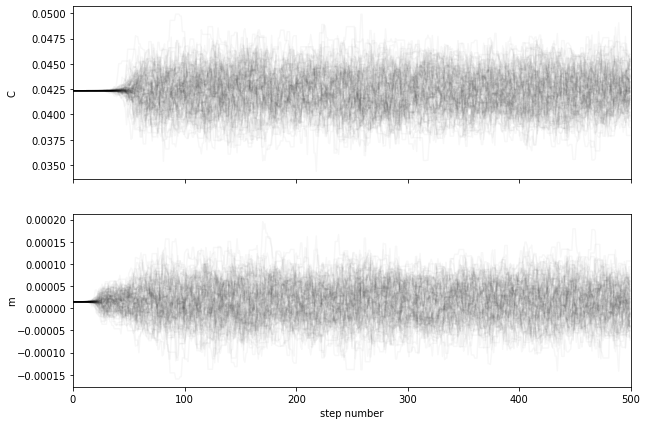

In [11]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

print (np.shape(samples))
print (np.shape(samples[:, :, 1]))
labels = ["C", "m"]
for i in range(ndim):
    ax = axes[i]
    # when you pass ax.plot a pair, the columns represent seperate data sets
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 500, 2)
(20000, 2)


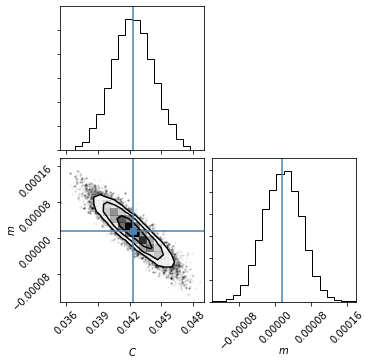

In [12]:
import corner
print(np.shape(samples))
samples = samples[:, 300:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["$C$", "$m$"],
                      truths=[C_fit, m_fit])

(20000, 2)


(0.04, 0.1)

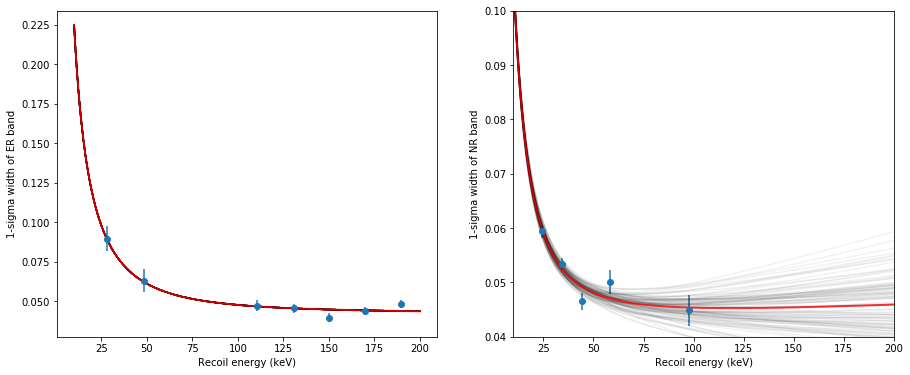

In [13]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

Erecoil = np.linspace(10, 200, 500)
print(np.shape(samples))
for C, m in samples[np.random.randint(len(samples), size=100)]:
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    ax1.plot(Erecoil, sigER_func(Erecoil), color="k", alpha=0.05)
    ax2.plot(Erecoil, sigNR_func(Erecoil), color="k", alpha=0.05)

# plot the best fit
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}

ref_sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                par_dict, aH)
    
ref_sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                  par_dict, aH, C_fit, m_fit)
ax1.plot(Erecoil, ref_sigER_func(Erecoil), color="r", lw=2, alpha=0.8)
ax2.plot(Erecoil, ref_sigNR_func(Erecoil), color="r", lw=2, alpha=0.8)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
ax2.set_ylim(0.04, 0.1)

In [14]:
sampsize=100
Erecoil_keV = np.linspace(10, 200, 500)
evec = np.zeros((np.size(Erecoil_keV),sampsize))

for i, (C, m) in enumerate(samples[np.random.randint(len(samples), size=sampsize)]):
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': A, 'b': B}
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    v = sigNR_func(Erecoil_keV)
    #print(np.std(v))
    #print(np.mean(v))
    evec[:,i] = v
   
upvec = np.mean(evec,axis=1)+np.std(evec,axis=1)
dnvec = np.mean(evec,axis=1)-np.std(evec,axis=1)

<ErrorbarContainer object of 3 artists>

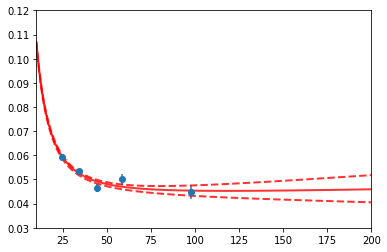

In [15]:
plt.plot(Erecoil_keV, ref_sigNR_func(Erecoil_keV), color="r", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)

plt.xlim(10, 200)
plt.ylim(0.03,0.12)
plt.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data", capsize=0)

In [16]:
if True:
    #save the results for the MS fit
    path='{}/{}/'.format('mcmc','edwdata_sys_error')

    filename = 'data/statistical_error_fits.h5'

    #remove vars
    f = h5py.File(filename,'a')
    exCms = path+'Cms' in f
    exm = path+'m' in f
    exsamp = path+'samples' in f
    exsampsize = path+'sampsize' in f
    exEr = path+'Er' in f
    exCsig_u = path+'Csig_u' in f
    exCsig_l = path+'Csig_l' in f
    exSigss = path+'Sigss' in f

    if exCms:
      del f[path+'Cms']
    if exm:
      del f[path+'m']
    if exsamp:
      del f[path+'samples']
    if exsampsize:
      del f[path+'sampsize']
    if exEr:
      del f[path+'Er']
    if exCsig_u:
      del f[path+'Csig_u']
    if exCsig_l:
      del f[path+'Csig_l']
    if exSigss:
      del f[path+'Sigss']

    # save the fit parameters
    dset = f.create_dataset(path+'Cms',np.shape(C_fit),dtype=np.dtype('float64').type)
    dset[...] = C_fit
    dset = f.create_dataset(path+'m',np.shape(m_fit),dtype=np.dtype('float64').type)
    dset[...] = m_fit
    
    # save the MCMC samples
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples
    dset = f.create_dataset(path+'sampsize',np.shape(sampsize),dtype=np.dtype('float64').type)
    dset[...] = sampsize
    
    # save the with of the NR band
    dset = f.create_dataset(path+'Er',np.shape(Erecoil_keV),dtype=np.dtype('float64').type, \
    compression="gzip")
    dset[...] = Erecoil_keV
    dset = f.create_dataset(path+'Csig_u',np.shape(upvec),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = upvec
    dset = f.create_dataset(path+'Csig_l',np.shape(dnvec),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = dnvec
    dset = f.create_dataset(path+'Sigss',np.shape(Erecoil_keV),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = ref_sigNR_func(Erecoil_keV)

    f.close()

# Only the systematic error

The above calculation includes both the statistical error (from the uncertainty on the data points) and the systematic error (from the uncertainty on parameters used in the fit like the voltage across the detector and the yield model).

In the interest of understanding how future analyses might improve on an estimate of the NR Fano, we examine the uncertainty introduced by the systematic error alone.

The statistical error is drawn from stat_uncertainty_C.ipynb.

In [17]:
# get the data mcmc_fits.h5 from stat_uncertainty_C.ipynb
filename_stat_error = 'data/systematic_error_fits.h5'
f = h5py.File(filename_stat_error,'r')

path='{}/{}/'.format('mcmc','edwdata_sys_error')

exCms = np.asarray(f[path+'Cms'])
exslope = np.asarray(f[path+'m'])
exEr = np.asarray(f[path+'Er'])
exCsig_u = np.asarray(f[path+'Csig_u'])
exCsig_l = np.asarray(f[path+'Csig_l'])
exSigss = np.asarray(f[path+'Sigss'])

f.close()

print (np.shape(exEr))

(500,)


<ErrorbarContainer object of 3 artists>

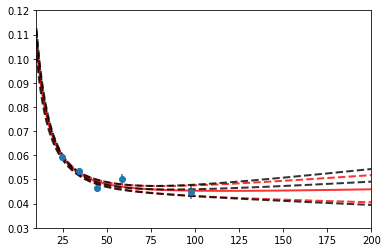

In [34]:
plt.plot(Erecoil_keV, ref_sigNR_func(Erecoil_keV), color="r", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)

# the best-fit is different for the two-parameter (C and m) fit
# than for the six-parameter fit

#plt.plot(exEr, ref_sigNR_func(exEr), color='k', lw=2, alpha=0.8)
a = ref_sigNR_func(exEr) + exCsig_u - exSigss
b = ref_sigNR_func(exEr) - (-exCsig_l + exSigss)
plt.plot(exEr, a, color="k",linestyle="--", lw=2, alpha=0.8)
plt.plot(exEr, b, color="k",linestyle="--", lw=2, alpha=0.8)
#plt.plot(exEr, exSigss, color="k",linestyle="--", lw=2, alpha=0.8)

plt.xlim(10, 200)
plt.ylim(0.03,0.12)
plt.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data", capsize=0)